# Word Level Federated Text Generation: Pre-training centrally and fine-tuning  in Federated style on Stack Overflow
- Arjun Singh
- 02-08-20

**About:**

This notebook runs the tensor-flow based training using an LSTM based network on Stackoverflow TFF text data and then leverages this pre-trained model to fine-tune Stackoverflow Data in a federated way using the TFF library. Although the same dataset is being used, different examples from the data are used for thr pre-train/fine-tune parts of the training process.

**Notes:**

- This notebook prepares the Stack Overflow dataset for word level language modeling using this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/dataset.py
).
- The metrics for model training come from this [module](https://github.com/tensorflow/federated/blob/master/tensorflow_federated/python/research/baselines/stackoverflow/metrics.py). 


**Data:** 
- https://www.kaggle.com/stackoverflow/stackoverflow

**License:** 
- https://creativecommons.org/licenses/by-sa/3.0/

**Data and Model References:**
- https://www.tensorflow.org/federated/api_docs/python/tff/simulation/datasets/stackoverflow/load_data
- https://github.com/tensorflow/federated/blob/master/docs/tutorials/federated_learning_for_text_generation.ipynb
- https://github.com/tensorflow/federated/tree/master/tensorflow_federated/python/research/baselines/stackoverflow
- https://www.tensorflow.org/tutorials/text/text_generation

**Environment Setup References:**
- https://www.tensorflow.org/install/gpu
- https://gist.github.com/matheustguimaraes/43e0b65aa534db4df2918f835b9b361d
- https://www.tensorflow.org/install/source#tested_build_configurations
- https://anbasile.github.io/programming/2017/06/25/jupyter-venv/

### Environment Setup
Pip install these packages in the order listed.

In [1]:
# !pip install --upgrade pip
# !pip install --upgrade tensorflow-federated
# !pip install tensorflow
# !pip install --upgrade tensorflow-gpu==2.0
# !pip install --upgrade nltk
# !pip install matplotlib
# !pip install nest_asyncio

### Imports

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.getcwd())))

In [4]:
import os, sys, io
sys.path.append(os.path.dirname(os.getcwd()))

In [5]:
from src import dataset, metrics, embeddings, model, validation, federated, generate_text

In [7]:
import collections
import functools
import six
import time
import string

import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

import tensorflow as tf
import tensorflow_federated as tff

### Set Compatability Behavior

In [8]:
tf.compat.v1.enable_v2_behavior()

### Check Tensorflow Install

In [9]:
print('Built with Cuda: {}'.format(tf.test.is_built_with_cuda()))
print('Build with GPU support: {}'.format(tf.test.is_built_with_gpu_support()))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Built with Cuda: False
Build with GPU support: False
Num GPUs Available:  0


### Set Tensorflow to Use GPU

In [10]:
physical_devices = tf.config.experimental.list_physical_devices(device_type=None)
# tf.config.experimental.set_memory_growth(physical_devices[-1], enable=True)
for device in physical_devices:
    print(device)

PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')


### Test TFF

In [11]:
tff.federated_computation(lambda: 'Hello, World!')()

'Hello, World!'

### Set Some Parameters for Preprocessing the Data and Training the Model

### Important Note: The goal is to run the pre-training using some data (centrally) anf then fine-tuning using different/new data in a federated manner. After a few experiments with how to go about this, we decided to only invoke the "construct_word_level_datasets()" function once with the centralized_train flag set to False. 

### This allows us to use the same train and val datasets as before for federated fine-tuning. However, now we get a much larger Test Dataset, which is actually being used to "centrally pre-train".

In [12]:
VOCAB_SIZE = 10000
BATCH_SIZE = 16
CLIENTS_EPOCHS_PER_ROUND = 1
MAX_SEQ_LENGTH = 20
MAX_ELEMENTS_PER_USER = 5000
CENTRALIZED_TRAIN = False
SHUFFLE_BUFFER_SIZE = 1000
NUM_VALIDATION_EXAMPLES = 10000

## These are actually not the test examples but the train examples
## being generated for centralized pre-training
NUM_TEST_EXAMPLES = 50000

NUM_ROUNDS = 500
NUM_TRAIN_CLIENTS = 10
UNIFORM_WEIGHTING = False

EMBEDDING_DIM = 100
RNN_UNITS = 256

## The next cell includes hyperparams for this test run

In [13]:
VOCAB_SIZE = 10000
BATCH_SIZE = 16
CLIENTS_EPOCHS_PER_ROUND = 1
MAX_SEQ_LENGTH = 20
MAX_ELEMENTS_PER_USER = 50
CENTRALIZED_TRAIN = False
SHUFFLE_BUFFER_SIZE = 1000
NUM_VALIDATION_EXAMPLES = 1000

## These are actually not the test examples but the train examples
## being generated for centralized pre-training
NUM_TEST_EXAMPLES = 500

NUM_ROUNDS = 5
NUM_TRAIN_CLIENTS = 2
UNIFORM_WEIGHTING = False

EMBEDDING_DIM = 100
RNN_UNITS = 256

### Load and Preprocess Word Level Datasets

In [14]:
train_data, val_data, test_data = dataset.construct_word_level_datasets(
    vocab_size=VOCAB_SIZE,
    batch_size=BATCH_SIZE,
    client_epochs_per_round=CLIENTS_EPOCHS_PER_ROUND,
    max_seq_len=MAX_SEQ_LENGTH,
    max_elements_per_user=MAX_ELEMENTS_PER_USER,
    centralized_train=CENTRALIZED_TRAIN,
    shuffle_buffer_size=SHUFFLE_BUFFER_SIZE,
    num_validation_examples=NUM_VALIDATION_EXAMPLES,
    num_test_examples=NUM_TEST_EXAMPLES)

9076670464/9076663578 [==============================] - 606s 0us/step


/Users/Arjun_Singh/miniconda3/envs/dl-class/lib/python3.6/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


In [15]:
type(train_data)

tensorflow_federated.python.simulation.client_data.ConcreteClientData

In [16]:
type(val_data)

tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter

In [17]:
type(test_data)

tensorflow.python.data.ops.dataset_ops.DatasetV1Adapter

### Retrieve the Dataset Vocab

#### Here the vocab remains the same for both the pre-training and fine-tuning since we're leveraging the same dataset

In [18]:
vocab = dataset.get_vocab(VOCAB_SIZE)

In [19]:
len(vocab)

10000

### Retrieve the Special Characters Created During Preprocessing
The four special tokens are:
- pad: padding token
- oov: out of vocabulary
- bos: begin of sentence
- eos: end of sentence

In [20]:
pad, oov, bos, eos = dataset.get_special_tokens(VOCAB_SIZE)

In [21]:
special2idx = dict(zip(['pad', 'oov', 'bos', 'eos'], [pad, oov, bos, eos]))
idx2special = {v:k for k, v in special2idx.items()}

### Set Vocabulary
Add one to account for the pad token which has idx 0.

In [22]:
word2idx = {word:i+1 for i, word in enumerate(vocab)}
idx2word = {i+1:word for i, word in enumerate(vocab)}

### Add Special Characters

In [23]:
word2idx = {**word2idx, **special2idx}
idx2word = {**idx2word, **idx2special}

### Reset Vocab Size
This accounts for having added the special characters.

In [24]:
EXTENDED_VOCAB_SIZE = VOCAB_SIZE + len(special2idx)

In [25]:
EXTENDED_VOCAB_SIZE

10004

### Load or Build the Model and Try Generating Some Text

In [26]:
embedding_matrix='uniform'

In [27]:
keras_model = model.build_model(extended_vocab_size=EXTENDED_VOCAB_SIZE,
                                embedding_dim=EMBEDDING_DIM,
                                embedding_matrix=embedding_matrix,
                                rnn_units=RNN_UNITS)

generate_text.generate_text(model=keras_model,
                            word2idx=word2idx,
                            idx2word=idx2word,
                            start_string='How are you today')

'how are you today ttf hopes clarifications confirm troubleshooting favour forked reshape one-time unwrap scrollbar circle product_id log4j argue promise reaching running x2 typed shoud mit actual asks rounded transient guarantees revised touched unread assemble garbage line-by-line re-add answer btw uiimage applications toolchain uk populating untested occasion fair 123 local suite lights suit looking'

### Create TFF Version of the Model to be Trained with Federated Averaging
- TFF uses a sample batch so it knows the types and shapes that your model expects.
- The model function then builds and compiles the model and creates a TFF version to be trained.

In [28]:
sample_batch = tf.nest.map_structure(lambda x: x.numpy(), next(iter(val_data)))

/Users/Arjun_Singh/miniconda3/envs/dl-class/lib/python3.6/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


In [30]:
#keras_model = build_model()
evaluation_metrics = validation.get_metrics(VOCAB_SIZE)
model.compile_model(keras_model, evaluation_metrics)

In [31]:
keras_model

In [32]:
keras_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model1_input (InputLayer)    [(None, None)]            0         
_________________________________________________________________
model1_embedding (Embedding) (None, None, 100)         1000400   
_________________________________________________________________
model1_lstm (LSTM)           (None, None, 256)         365568    
_________________________________________________________________
dense (Dense)                (None, None, 100)         25700     
_________________________________________________________________
dense_1 (Dense)              (None, None, 10004)       1010404   
Total params: 2,402,072
Trainable params: 2,402,072
Non-trainable params: 0
_________________________________________________________________


In [33]:
PRE_TRAIN_EPOCHS = 10

## An example of this kind of pre-training is when we may want to train the G-board keyboards on user's personal devices in a personalized manner using Federated Learning, but we can centrally train on simulated or dummy text conversations

### Following is the pre-training for the SO dataset using the tensor-flow central training for 50000 examples (called the test_data) over 10 epochs

In [34]:
history = keras_model.fit(test_data, epochs=PRE_TRAIN_EPOCHS) #, callbacks=[checkpoint_callback]

Epoch 1/10


/Users/Arjun_Singh/miniconda3/envs/dl-class/lib/python3.6/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


5/5 [==============================] - 13s 3s/step - loss: 6.2858 - num_tokens: 6467.0000 - num_tokens_no_oov: 6262.0000 - num_batches: 5.0000 - num_examples: 500.0000 - accuracy: 0.0360 - accuracy_no_oov: 0.0370 - accuracy_no_oov_no_eos: 0.0117
Epoch 2/10
5/5 [==============================] - 6s 1s/step - loss: 6.4774 - num_tokens: 6675.0000 - num_tokens_no_oov: 6439.0000 - num_batches: 5.0000 - num_examples: 500.0000 - accuracy: 0.0461 - accuracy_no_oov: 0.0478 - accuracy_no_oov_no_eos: 0.0061
Epoch 3/10
5/5 [==============================] - 6s 1s/step - loss: 5.8826 - num_tokens: 6463.0000 - num_tokens_no_oov: 6270.0000 - num_batches: 5.0000 - num_examples: 500.0000 - accuracy: 0.0302 - accuracy_no_oov: 0.0311 - accuracy_no_oov_no_eos: 0.0059
Epoch 4/10
5/5 [==============================] - 6s 1s/step - loss: 5.0765 - num_tokens: 6596.0000 - num_tokens_no_oov: 6396.0000 - num_batches: 5.0000 - num_examples: 500.0000 - accuracy: 0.0327 - accuracy_no_oov: 0.0338 - accuracy_no_oov_n

In [35]:
keras_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model1_input (InputLayer)    [(None, None)]            0         
_________________________________________________________________
model1_embedding (Embedding) (None, None, 100)         1000400   
_________________________________________________________________
model1_lstm (LSTM)           (None, None, 256)         365568    
_________________________________________________________________
dense (Dense)                (None, None, 100)         25700     
_________________________________________________________________
dense_1 (Dense)              (None, None, 10004)       1010404   
Total params: 2,402,072
Trainable params: 2,402,072
Non-trainable params: 0
_________________________________________________________________


In [36]:
type(keras_model)

tensorflow.python.keras.engine.training.Model

In [37]:
keras_model.evaluate(val_data)

/Users/Arjun_Singh/miniconda3/envs/dl-class/lib/python3.6/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


10/10 [==============================] - 8s 844ms/step - loss: 4.1945 - num_tokens: 12804.0000 - num_tokens_no_oov: 12427.0000 - num_batches: 10.0000 - num_examples: 1000.0000 - accuracy: 0.0064 - accuracy_no_oov: 0.0066 - accuracy_no_oov_no_eos: 0.0000e+00


[4.194501662254334, 12804, 12427, 10, 1000, 0.0064042485, 0.0065985355, 0.0]

### Initialize Train and Validation Model Trackers to be Used Below

In [52]:
evaluation_metric_names = ['loss',
                           'num_tokens',
                           'num_tokens_no_oov',
                           'num_batches',
                           'num_examples',
                           'accuracy',
                           'accuracy_no_oov',
                           'accuracy_no_oov_no_oes']

### Set the Default Executor

In [39]:
tff.framework.set_default_executor(tff.framework.create_local_executor(max_fanout=10))

### Create an Iterative Process

In [40]:
iterative_process = (
      tff.learning.federated_averaging.build_federated_averaging_process(
          model_fn=lambda : model.model_fn(extended_vocab_size=EXTENDED_VOCAB_SIZE,
                        embedding_dim=EMBEDDING_DIM,
                        embedding_matrix=embedding_matrix,
                        rnn_units=RNN_UNITS,
                        vocab_size=VOCAB_SIZE,
                        sample_batch=sample_batch),
          server_optimizer_fn=federated.server_optimizer_fn,
          client_weight_fn=federated.client_weight_fn))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Next we initialize the model for the Federated Learning (fine-tuning) process with the weights learned from the previously pre-trained model (saved as keras_model)

### It can be seen next the only the trainable_weights need to be transferred to the model for fine-tuning, as the non_trainable_weights are empty.

### It can also be seen that trainable variables are identical to the trainable weights for the pre-trained model

In [42]:
from src import transfer_learning

### Following is the step where the transfer learning actually takes place

In [43]:
server_state = transfer_learning.learn_from_pretrained_model(iterative_process, keras_model)

### Now it can be seen that the relevant weights are identical

In [44]:
keras_model.trainable_weights[0].numpy() == server_state.model[0][0]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [45]:
keras_model.trainable_weights[1].numpy() == server_state.model[0][1]

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [47]:
NUM_ROUNDS = 5

In [46]:
from tqdm import tqdm

### Next we perform the actual FL based fine-tuning, following which we compare the results (loss and accuracy) from this pretraining/fine-tuning based approach to the earlier approach of only performing FL based training without any form of pre-training

In [48]:
SAVE_DIR = 'temp_results/'

In [53]:
train_metrics_tracker = validation.model_history_tracker(evaluation_metric_names)
val_metrics_tracker = validation.model_history_tracker(evaluation_metric_names)


  0%|          | 0/5 [00:00<?, ?it/s]

Evaluating before training round #0 on 1000 examples.


/Users/Arjun_Singh/miniconda3/envs/dl-class/lib/python3.6/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


10/10 [==============================] - 11s 1s/step - loss: 4.6050 - num_tokens: 13027.0000 - num_tokens_no_oov: 12597.0000 - num_batches: 10.0000 - num_examples: 1000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 2 new clients.



 20%|██        | 1/5 [00:32<02:10, 32.72s/it]

Round: 0
   Loss: 4.46339035
   num_batches: 8
   num_examples: 100
   num_tokens: 1252
   num_tokens_no_oov: 1211
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #1 on 1000 examples.


/Users/Arjun_Singh/miniconda3/envs/dl-class/lib/python3.6/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


10/10 [==============================] - 12s 1s/step - loss: 4.7310 - num_tokens: 13516.0000 - num_tokens_no_oov: 13078.0000 - num_batches: 10.0000 - num_examples: 1000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 2 new clients.



 40%|████      | 2/5 [01:04<01:37, 32.35s/it]

Round: 1
   Loss: 4.45650196
   num_batches: 8
   num_examples: 100
   num_tokens: 1263
   num_tokens_no_oov: 1224
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #2 on 1000 examples.


/Users/Arjun_Singh/miniconda3/envs/dl-class/lib/python3.6/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


10/10 [==============================] - 11s 1s/step - loss: 4.7579 - num_tokens: 13637.0000 - num_tokens_no_oov: 13161.0000 - num_batches: 10.0000 - num_examples: 1000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 2 new clients.



 60%|██████    | 3/5 [01:28<00:59, 29.90s/it]

Round: 2
   Loss: 4.29891586
   num_batches: 8
   num_examples: 100
   num_tokens: 1182
   num_tokens_no_oov: 1147
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #3 on 1000 examples.


/Users/Arjun_Singh/miniconda3/envs/dl-class/lib/python3.6/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


10/10 [==============================] - 10s 1s/step - loss: 4.5425 - num_tokens: 13215.0000 - num_tokens_no_oov: 12792.0000 - num_batches: 10.0000 - num_examples: 1000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 2 new clients.



 80%|████████  | 4/5 [01:52<00:28, 28.16s/it]

Round: 3
   Loss: 5.11755848
   num_batches: 8
   num_examples: 100
   num_tokens: 1426
   num_tokens_no_oov: 1398
   accuracy: 0.00000
   accuracy_no_oov: 0.00000
Evaluating before training round #4 on 1000 examples.


/Users/Arjun_Singh/miniconda3/envs/dl-class/lib/python3.6/site-packages/tensorflow_federated/python/simulation/hdf5_client_data.py:69: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  collections.OrderedDict((name, ds.value) for name, ds in sorted(


10/10 [==============================] - 7s 703ms/step - loss: 4.5733 - num_tokens: 13469.0000 - num_tokens_no_oov: 13062.0000 - num_batches: 10.0000 - num_examples: 1000.0000 - accuracy: 0.0000e+00 - accuracy_no_oov: 0.0000e+00 - accuracy_no_oov_no_eos: 0.0000e+00
Sampling 2 new clients.



100%|██████████| 5/5 [02:17<00:00, 27.30s/it]

Round: 4
   Loss: 4.28772593
   num_batches: 8
   num_examples: 100
   num_tokens: 1223
   num_tokens_no_oov: 1175
   accuracy: 0.00000
   accuracy_no_oov: 0.00000


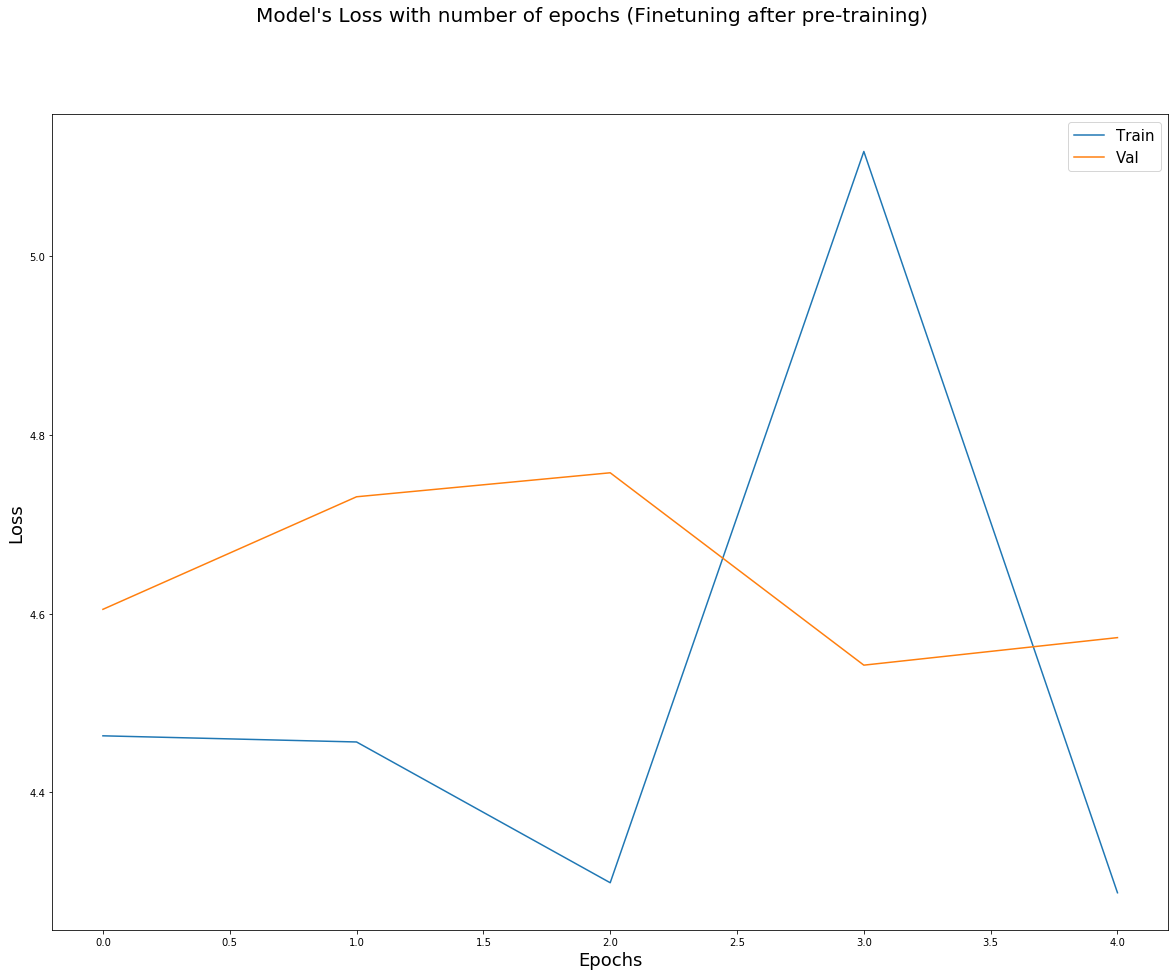

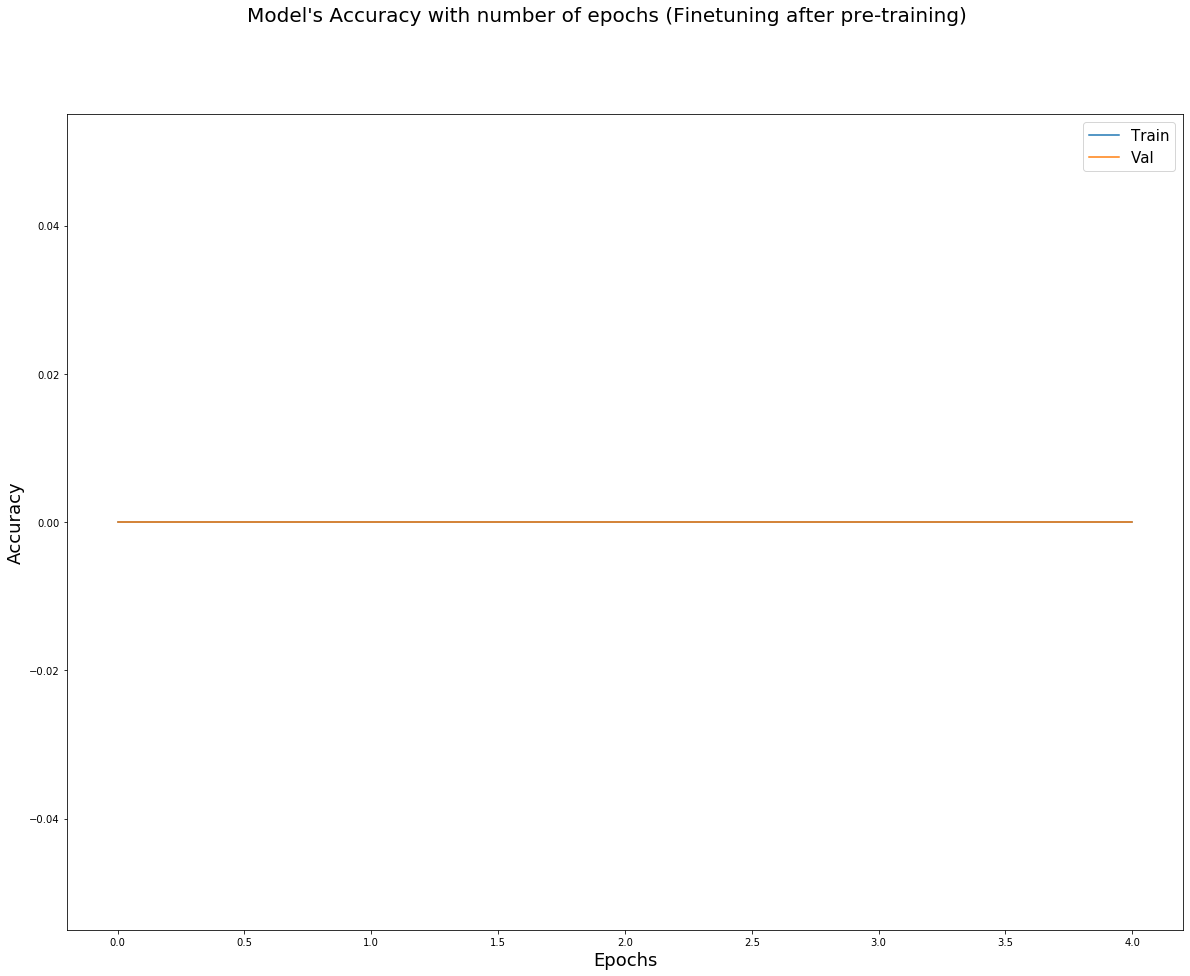

In [54]:
try:
    for round_num in tqdm(range(0, NUM_ROUNDS)):

        # Examine validation metrics
        print(f'Evaluating before training round #{round_num} on {NUM_VALIDATION_EXAMPLES} examples.')
        #keras_evaluate(server_state, val_data)
        
        validation.keras_evaluate(state=server_state,
                          val_dataset=val_data,
                          extended_vocab_size=EXTENDED_VOCAB_SIZE,
                          vocab_size=VOCAB_SIZE,
                          embedding_dim=EMBEDDING_DIM,
                          embedding_matrix=embedding_matrix,
                          rnn_units=RNN_UNITS,
                          metrics_tracker=val_metrics_tracker)

        # Sample train clients to create a train dataset
        print(f'Sampling {NUM_TRAIN_CLIENTS} new clients.')
        #train_clients = get_sample_clients(train_data, num_clients=NUM_TRAIN_CLIENTS)
        train_clients = federated.get_sample_clients(dataset=train_data, num_clients=NUM_TRAIN_CLIENTS)
        train_datasets = [train_data.create_tf_dataset_for_client(client) for client in train_clients]

        # Apply federated training round
        server_state, server_metrics = iterative_process.next(server_state, train_datasets)

        # Examine training metrics
        print('Round: {}'.format(round_num))
        print('   Loss: {:.8f}'.format(server_metrics.loss))
        print('   num_batches: {}'.format(server_metrics.num_batches))
        print('   num_examples: {}'.format(server_metrics.num_examples))
        print('   num_tokens: {}'.format(server_metrics.num_tokens))
        print('   num_tokens_no_oov: {}'.format(server_metrics.num_tokens_no_oov))
        print('   accuracy: {:.5f}'.format(server_metrics.accuracy))
        print('   accuracy_no_oov: {:.5f}'.format(server_metrics.accuracy_no_oov))

        # Add train metrics to tracker
        train_metrics_tracker.add_metrics_by_name('loss', server_metrics.loss)
        train_metrics_tracker.add_metrics_by_name('accuracy', server_metrics.accuracy)
        
        np.save(SAVE_DIR + 'train_accuracy_finetuning.npy', train_metrics_tracker.get_metrics_by_name('accuracy'))
        np.save(SAVE_DIR + 'val_accuracy_finetuning.npy', val_metrics_tracker.get_metrics_by_name('accuracy'))
        
        np.save(SAVE_DIR + 'train_loss_finetuning.npy', train_metrics_tracker.get_metrics_by_name('loss'))
        np.save(SAVE_DIR + 'val_loss_finetuning.npy', val_metrics_tracker.get_metrics_by_name('loss'))

except KeyboardInterrupt as ke:
    print('Interrupted')
except:
    import traceback
    traceback.print_exc()
finally:
    fig, ax = plt.subplots(figsize=(20, 15))
    x_axis = range(0, NUM_ROUNDS)
    ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('loss'), label='Train')
    ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('loss'), label='Val')
    ax.legend(loc='best', prop={'size': 15})
    fig.suptitle('Model\'s Loss with number of epochs (Finetuning after pre-training)', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Loss', fontsize=18)
    fig.savefig(SAVE_DIR + 'Loss_with_Epochs_finetuning.jpg')
    plt.show()
    
    fig2, ax2 = plt.subplots(figsize=(20, 15))
    ax2.plot(x_axis, train_metrics_tracker.get_metrics_by_name('accuracy'), label='Train')
    ax2.plot(x_axis, val_metrics_tracker.get_metrics_by_name('accuracy'), label='Val')
    ax2.legend(loc='best', prop={'size': 15})
    fig2.suptitle('Model\'s Accuracy with number of epochs (Finetuning after pre-training)', fontsize=20)
    plt.xlabel('Epochs', fontsize=18)
    plt.ylabel('Accuracy', fontsize=18)
    fig2.savefig(SAVE_DIR + 'Accuracy_with_Epochs_finetuning.jpg')
    plt.show()

### Retrieve the previously saved numpy arrays for Loss and Accuracy for Training without any pretraining

In [82]:
import numpy as np
train_loss_no_pt_embed = np.load('train_loss_no_pt_embed.npy')
train_accuracy_no_pt_embed = np.load('train_accuracy_no_pt_embed.npy')
val_loss_no_pt_embed = np.load('val_loss_no_pt_embed.npy')
val_accuracy_no_pt_embed = np.load('val_accuracy_no_pt_embed.npy')

### Plot Model's Loss for both models, with and without any pre-training

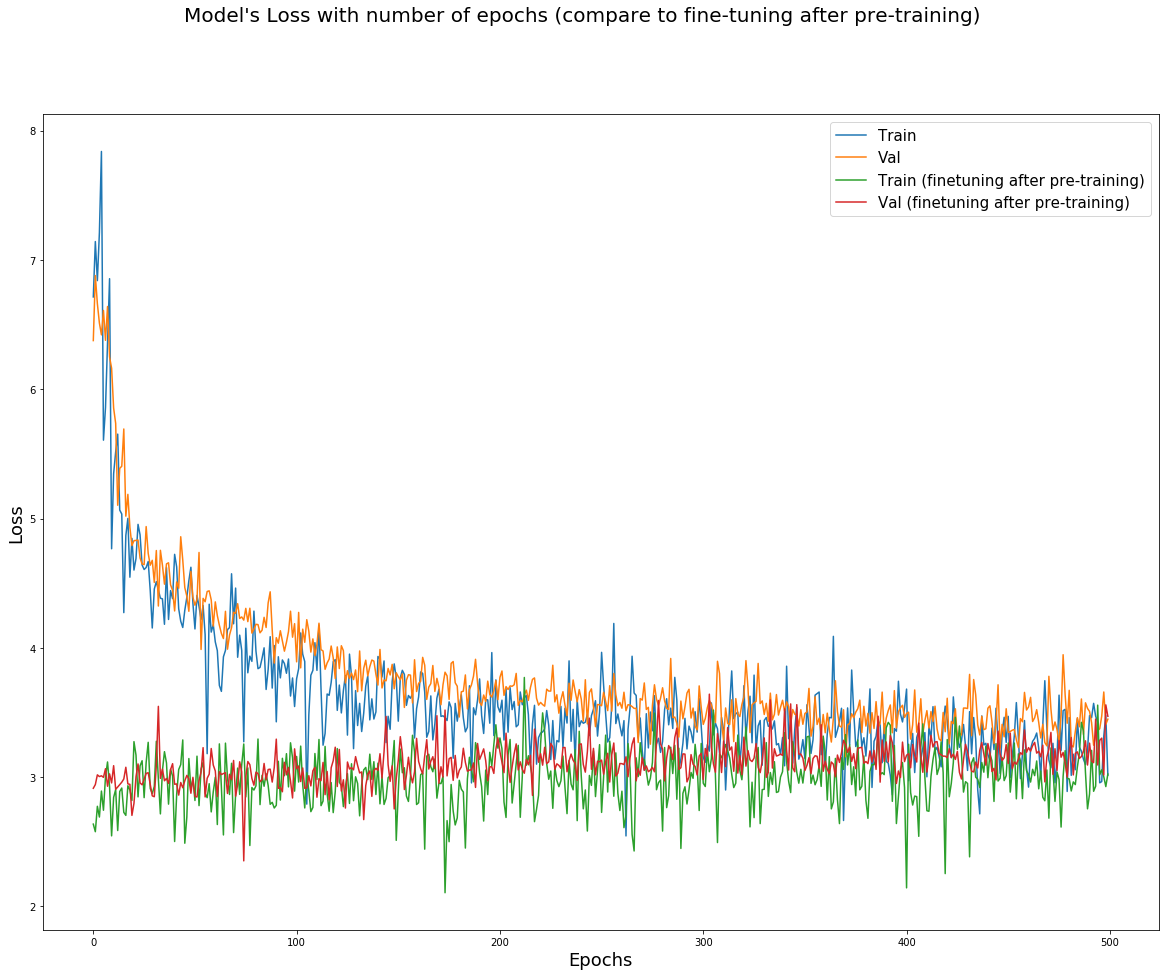

In [84]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_loss_no_pt_embed, label='Train')
ax.plot(x_axis, val_loss_no_pt_embed, label='Val')
ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('loss'), label='Train (finetuning after pre-training)')
ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('loss'), label='Val (finetuning after pre-training)')
ax.legend(loc='best', prop={'size': 15})
fig.suptitle('Model\'s Loss with number of epochs (compare to fine-tuning after pre-training)', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Loss', fontsize=18)
fig.savefig('Loss_with_Epochs_compare_finetuning.jpg')
plt.show()

### Plot Model's Accuracy for both models, with and without any pre-training

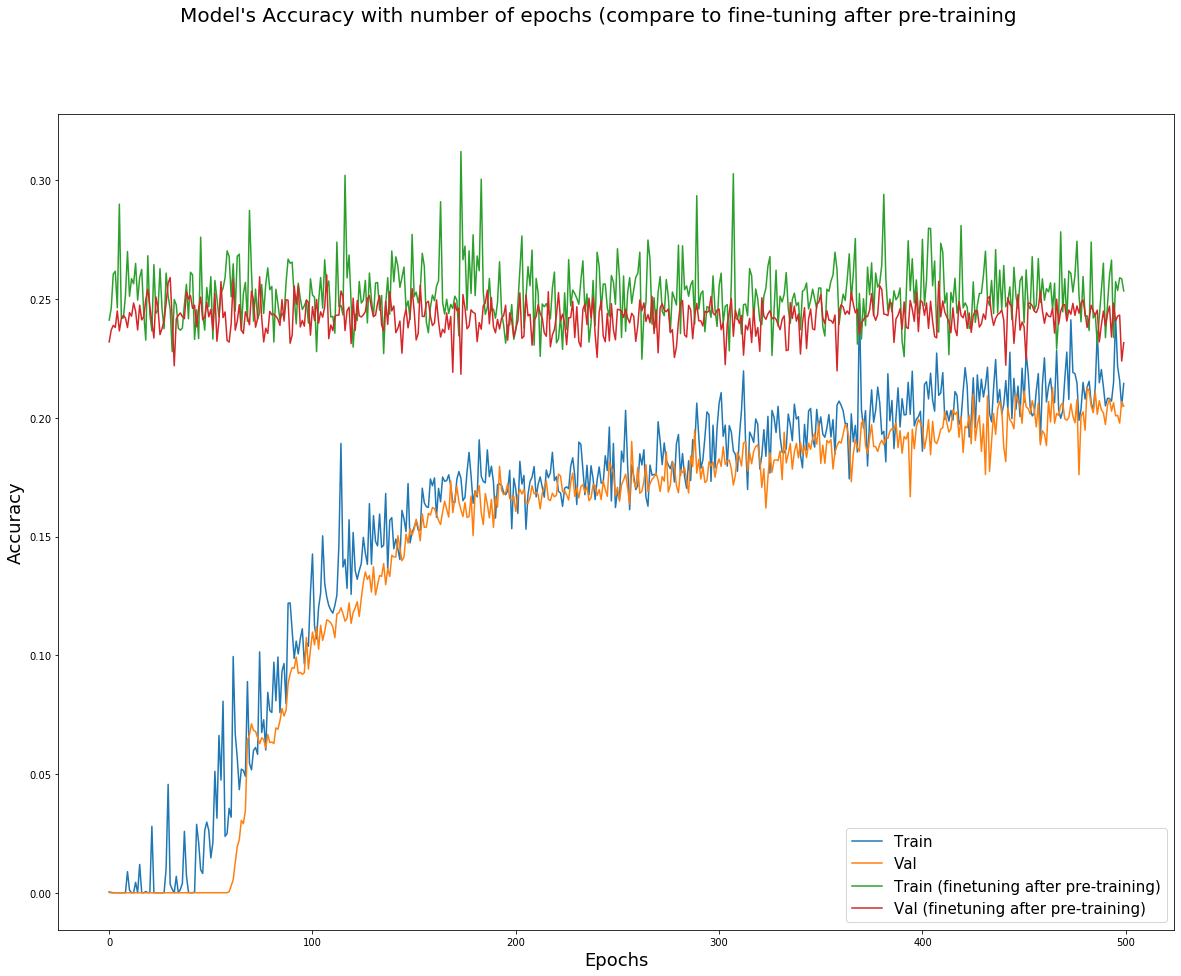

In [85]:
fig, ax = plt.subplots(figsize=(20, 15))
x_axis = range(0, NUM_ROUNDS)
ax.plot(x_axis, train_accuracy_no_pt_embed, label='Train')
ax.plot(x_axis, val_accuracy_no_pt_embed, label='Val')
ax.plot(x_axis, train_metrics_tracker.get_metrics_by_name('accuracy'), label='Train (finetuning after pre-training)')
ax.plot(x_axis, val_metrics_tracker.get_metrics_by_name('accuracy'), label='Val (finetuning after pre-training)')
ax.legend(loc='best', prop={'size': 15})
fig.suptitle('Model\'s Accuracy with number of epochs (compare to fine-tuning after pre-training', fontsize=20)
plt.xlabel('Epochs', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
fig.savefig('Accuracy_with_Epochs_compare_finetuning.jpg')
plt.show()

### Get Final Evaluation

In [86]:
keras_evaluate(server_state, val_data)

/home/singh_arjun1313/anaconda3/lib/python3.7/site-packages/h5py/_hl/dataset.py:313: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  "Use dataset[()] instead.", H5pyDeprecationWarning)


100/100 [==============================] - 22s 222ms/step - loss: 3.1189 - num_tokens: 131630.0000 - num_tokens_no_oov: 127710.0000 - num_batches: 100.0000 - num_examples: 10000.0000 - accuracy: 0.2455 - accuracy_no_oov: 0.2420 - accuracy_no_oov_no_eos: 0.2025


### Generate Text

In [87]:
tff.learning.assign_weights_to_keras_model(keras_model, server_state.model)
print(generate_text(keras_model, "How are you today"))

how are you today , ? eos pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad pad
